<a href="https://colab.research.google.com/github/G544/galinanana_ml/blob/main/kaggle/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"galinanana","key":"8147c232cb591bab100fb9318cb5ce2d"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 25.1MB/s]


In [4]:
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as plt 
import matplotlib.pyplot as plt
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

# Чтение данных


In [6]:
filezip = '/content/titanic.zip'

z = ZipFile(filezip)
print(z.infolist())
with ZipFile(filezip, 'r') as zip_file:
    zip_file.extract('train.csv', '.')
    zip_file.extract('test.csv', '.')
    zip_file.extract('gender_submission.csv', '.')

[<ZipInfo filename='gender_submission.csv' compress_type=deflate file_size=3258 compress_size=872>, <ZipInfo filename='test.csv' compress_type=deflate file_size=28629 compress_size=11171>, <ZipInfo filename='train.csv' compress_type=deflate file_size=61194 compress_size=22388>]


# First View

In [7]:
data = pd.read_csv('/content/train.csv')
data.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
790,791,0,3,"Keane, Mr. Andrew ""Andy""",male,NaN,0,0,12460,7.7500,NaN,Q
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
843,844,0,3,"Lemberopolous, Mr. Peter L",male,34.5,0,0,2683,6.4375,NaN,C


Вещественные признаки : Age, Fare  
Категориальные : Sibsp, Cabin, Embarked, Sex, Parch, Pclass


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


# First View

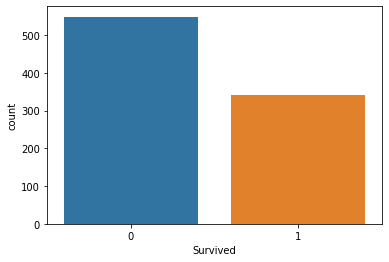

In [10]:
sns.countplot(x='Survived',data=data)
plt.show()

In [11]:
balance = {0:data['Survived'].value_counts()[0]/data.shape[0], 1:data['Survived'].value_counts()[1]/data.shape[0]}

Видим, что классы несбалансированы. Чтобы понимать более справедливое распределение величин сбланасируем классы


In [12]:
ros = RandomOverSampler(random_state=0)
X_resampled_vis, y_resampled_vis = ros.fit_resample(data.drop('Survived', axis=1), data['Survived'])
vis_df =X_resampled_vis.copy(deep=True)
vis_df['Survived'] = y_resampled_vis

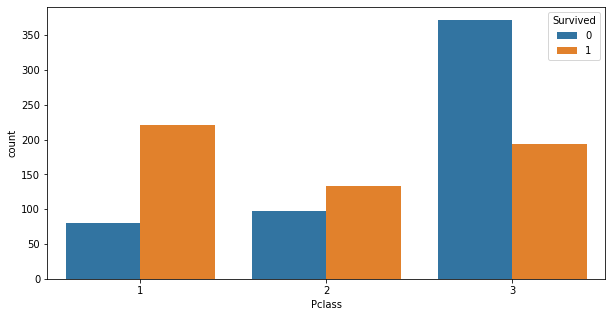

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x='Pclass', hue='Survived', data=vis_df)

Можно заметить, что представители первого класса выживали чаще, а представители 3 класса чаще гибли

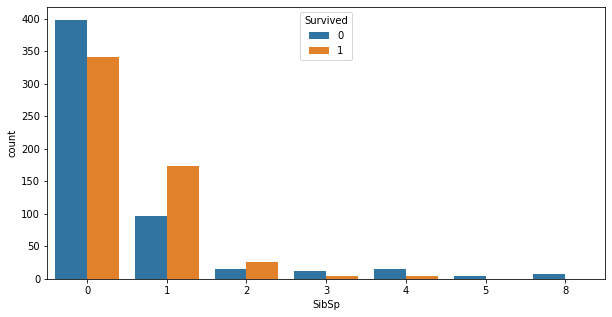

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='SibSp', hue='Survived', data=vis_df)

Люди имеющие одного родственника выживали чаще,чем погибали

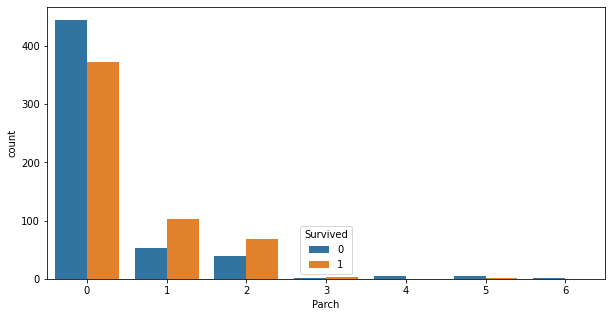

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(x='Parch', hue='Survived', data=vis_df)

Люди имеющие 1 или двух членов семьи выживали чуть чуть чаще

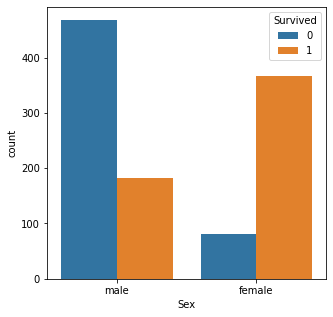

In [16]:
plt.figure(figsize=(5,5))
sns.countplot(x='Sex',hue='Survived', data=vis_df)

Женщины выживали намного чаще, чем погибали, чего нельзя сказать о мужчинах

Оценим количественные переменные


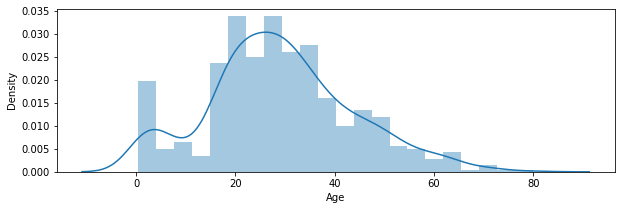

In [17]:
plt.figure(figsize=(10,3))
sns.distplot(vis_df['Age'])
plt.show()


In [18]:
k2, p = stats.normaltest(vis_df['Age'].fillna(24))
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 5.1571e-15
The null hypothesis can be rejected


Нулевая гипотеза о нормальности распределении отвергается. Попробуем применить преобразование бокса-кокса и отбросить выбросы

In [19]:
k2, p = stats.normaltest((stats.boxcox(vis_df[vis_df['Age']< 65]['Age'].fillna(24), lmbda=0.765)))
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
k2, p = stats.normaltest(stats.boxcox(vis_df['Fare']+1, lmbda=0))

p = 0.00653046
The null hypothesis cannot be rejected


Нулевая гипотеза по прежнему овтергается

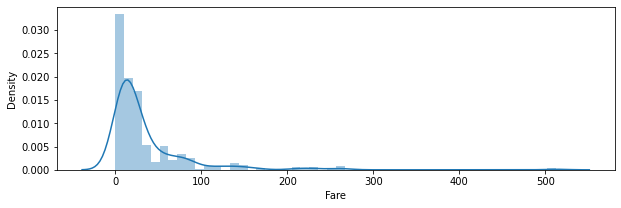

In [20]:
plt.figure(figsize=(10,3))
sns.distplot((vis_df['Fare']))

In [21]:
k2, p = stats.normaltest(vis_df['Fare'])
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 1.04751e-222
The null hypothesis can be rejected


Нулевая гипотеза отвергается

In [22]:
k2, p = stats.normaltest(stats.boxcox(vis_df['Fare']+1, lmbda=0))
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 9.19718e-08
The null hypothesis can be rejected


p value значительно увеличилось, но нулевая гипотеза по прежнему отвергается. Распредление немного похоже на догнормальное, но использование логарифма от распределения также не дает принятия нулевой гипотезы

# Features extraction


На данном этапе создадим как можно больше разных фичей, а далее отберем какие наборы дают лучшие результаты при обучении

In [51]:
max_corr = abs(data.corr()['Age']).sort_values().index[-3:-1]
corr_df = data[~data['Age'].isna()][max_corr]
corr_target = data[~data['Age'].isna()]['Age']
lr_corr = LinearRegression()
lr_corr.fit(corr_df, corr_target)
def preproc(data):
  global lr_corr
  sc = StandardScaler()
  df = sc.fit_transform(data[['Age', 'Fare']])
  df = pd.DataFrame(columns = sc.get_feature_names_out(),data = df)
  data['Cabin_ffil'] =( ~data['Cabin'].isna()).astype(int)
  data['Ticket_digit'] = [s[0].isdigit() for s in data['Ticket']]
  data['Ticket_digit'] = data['Ticket_digit'].astype(int)
  data['Embarked'].fillna('Nan', inplace=True)
  data['Age_24'] = data['Age'].fillna(24.0, inplace=True)
  data['Age_mean'] = data['Age'].fillna(data['Age'].mean(), inplace=True)
  data['Age_bc'] = stats.boxcox(data['Age'], lmbda=0.765)
  data['Fare_bc'] = stats.boxcox(data['Fare']+1)[0]
 # data['Age_corr'] = data['Age'].fillna(dict(zip(data.loc[data['Age'].isna()].index, list(lr_corr.predict(data[data['Age'].isna()][max_corr])))))
  data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True, axis=1)
  data['SibSp'] = data['SibSp'].astype(str)
  data['Parch'] = data['Parch'].astype(str)
  data['Pclass'] = data['Pclass'].astype(str)
  #df = pd.concat([data,pd.get_dummies(data[['Sex', 'Embarked']])], axis=1)
  df = pd.concat([data,pd.get_dummies(data[['Sex', 'Embarked', 'Pclass', 'SibSp','Parch']])], axis=1)
  #df = pd.concat([data,pd.get_dummies(data[['Sex', 'Embarked', 'Pclass']])], axis=1)
  df.drop(['Sex', 'Embarked','Pclass', 'SibSp','Parch'], axis=1, inplace=True)
  if 'Embarked_Nan' in list(df.columns):
    df.drop('Embarked_Nan', axis=1, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [50]:
data1 = data.copy(deep=True)
data = data[(data['Age']<65)]
target = data['Survived']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(data.drop('Survived', axis=1), target)
X_resampled = preproc(X_resampled)
X_train, X_test, y_train,  y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=19)
#X_train, X_test, y_train,  y_test = train_test_split(df, target, test_size=0.3)

ValueError: ignored

In [30]:
logreg = LogisticRegression()
ridge = RidgeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
logreg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
nb.fit(X_train, y_train)
rf.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_pred_rd = ridge.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
for y, name in zip((y_pred_lr, y_pred_rd, y_pred_nb, y_pred_rf), ('lr', 'ridge', 'nb','rf')):
  pred_ac = round(accuracy_score(y, y_test),3)
  pred_pr = round(precision_score(y, y_test),3)
  pred_recall = round(recall_score(y, y_test),3)
  pred_f = round(f1_score(y, y_test),3)
  pred_roc = round(roc_auc_score(y, y_test),3)
  print(f'Score for {name}  ')
  print('')
  print(f'Accuracy для {name} {pred_ac}  ')
  print(f'Precision для {name} {pred_pr}  ')
  print(f'Recall для {name} {pred_recall}  ')
  print('')

Score for lr  

Accuracy для lr 0.775  
Precision для lr 0.759  
Recall для lr 0.829  

Score for ridge  

Accuracy для ridge 0.763  
Precision для ridge 0.716  
Recall для ridge 0.842  

Score for nb  

Accuracy для nb 0.767  
Precision для nb 0.759  
Recall для nb 0.817  

Score for rf  

Accuracy для rf 0.815  
Precision для rf 0.816  
Recall для rf 0.852  



# Настройка модели


In [ ]:
params_dict = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[0.00001,0.0001, 0.001,0.01,0.1,1,10,100,1000], 'tol': [1e-5, 1e-6]}
lr = LogisticRegression( solver='saga')
gv = GridSearchCV(lr, param_grid=params_dict, scoring = 'accuracy')
gv.fit(df, target)

GridSearchCV(estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'tol': [1e-05, 1e-06]},
             scoring='accuracy')

In [ ]:
lr_best = LogisticRegression(solver='saga', **gv.best_params_)
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
#lr_best.fit(df,target)

0.7333333333333333


In [ ]:
BC_param_grid = {
'bootstrap': [True, False],
'bootstrap_features': [True, False],    
'n_estimators': [5, 10, 15],
'max_samples' : [0.6, 0.8, 1.0],
'base_estimator__penalty': ['l1', 'l2', 'elasticnet'],
'base_estimator__C':[0.001,0.01,0.1,1,10,100,1000]
}
bag_cl = BaggingClassifier(lr)
gv_bag = GridSearchCV(bag_cl, param_grid=BC_param_grid, scoring = 'accuracy')
gv_bag.fit(df, target)
#y_pred = bag_cl.predict(X_test)
#print(accuracy_score(y_test, y_pred))

GridSearchCV(estimator=BaggingClassifier(base_estimator=LogisticRegression(solver='saga')),
             param_grid={'base_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                               1000],
                         'base_estimator__penalty': ['l1', 'l2', 'elasticnet'],
                         'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_samples': [0.6, 0.8, 1.0],
                         'n_estimators': [5, 10, 15]},
             scoring='accuracy')

In [ ]:
scores_threshold = []
for i in np.arange(0,1,0.001):
  y_pred = (lr_best.predict_proba(X_test)[:,1]>i).astype(int)
  scores_threshold.append(accuracy_score(y_test, y_pred))

max(scores_threshold)

0.7454545454545455

Tuning Лог регрессии особенно ничего не дал

In [ ]:
params_dict = {'criterion': ['entropy', 'gini', 'log_loss'], 'n_estimators':[50, 100, 500], 'max_depth':[4,8,'None'], 'min_samples_split':[1,2,3, 6]}
rf = RandomForestClassifier(class_weight = balance)
gv = GridSearchCV(rf, param_grid=params_dict, scoring = 'accuracy')
gv.fit(df, target)

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                                            1: 0.3838383838383838}),
             param_grid={'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_depth': [4, 8, 'None'],
                         'min_samples_split': [1, 2, 3, 6],
                         'n_estimators': [50, 100, 500]},
             scoring='accuracy')

In [ ]:
gv.best_estimator_

RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                     1: 0.3838383838383838},
                       max_depth=8, n_estimators=500)

In [ ]:
rf = RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                     1: 0.3838383838383838},
                       max_depth=8, n_estimators=500)
rf.fit(df, target)

RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                     1: 0.3838383838383838},
                       max_depth=8, n_estimators=500)

# XGBoost

In [39]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.8072289156626506


In [40]:
param_grid =  {'n_estimators':[10000, 5000,1000, 150], 'learning_rate' : [1e-3,1e-4, 1e-2, 1e-1, 1]} 
gv = GridSearchCV(xgb, param_grid = param_grid, scoring = 'accuracy', verbose=True)
gv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.0001, 0.01, 0.1, 1],
                         'n_estimators': [10000, 5000, 1000, 150]},
             scoring='accuracy', verbose=True)

# Submission

In [41]:
test = pd.read_csv('/content/test.csv')
for_analys = test.copy(deep=True)
id = test['PassengerId']
X_submiss = preproc(test)
diff = list(set(X_train.columns).difference(set(X_submiss.columns)))
dict_idx = ()
for itm in diff:
  idx = list(X_train.columns).index(itm)
  X_submiss.insert(idx, itm, 0)

In [42]:
def make_submission(model, X_submiss,name = 'submission.csv', refit=True, X_train = 0, y_train= 0):
  model.fit(X_train, y_train)
  y_submiss = model.predict(X_submiss)
  d = {'PassengerId':id, 'Survived':y_submiss}
  pd.DataFrame(d).to_csv(name, index=None)
  return pd.DataFrame(d)

In [45]:
xgb_pr = make_submission(xgb, X_submiss,name = 'submission_xgb.csv', X_train = X_resampled, y_train = y_resampled)
rf_pr = make_submission(rf, X_submiss, name = 'submission_rf.csv', X_train = X_resampled, y_train = y_resampled)
lr_best_pr = make_submission(lr, X_submiss,name = 'submission_xgb.csv', X_train = X_resampled, y_train = y_resampled)
nb_pr = make_submission(nb, X_submiss, name = 'submission_rf.csv', X_train = X_resampled, y_train = y_resampled)
ridge_pr = make_submission(ridge, X_submiss,name = 'submission_xgb.csv', X_train = X_resampled, y_train = y_resampled)

NameError: ignored

In [ ]:
new_forecast = dict(zip(rf_pr.copy(deep=True)['Survived'].index, rf_pr.copy(deep=True)['Survived'].to_list()))
new_partial = (xgb_pr[(ridge_pr['Survived']- rf_pr['Survived']) != 0]['Survived'])
for item in new_forecast.keys():
  if item in new_partial.index:
    new_forecast[item] = new_partial[item]

In [ ]:
!kaggle competitions submit -c titanic -f submission_rf.csv -m best_xgb